In [1]:
#data libraries
import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

import warnings
warnings.filterwarnings('ignore')


In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

# Load Data

In [3]:
#Reading training data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#creating submission dataframe
submission = pd.DataFrame(columns= ['Id', 'SalePrice'])
submission['Id'] = df_test['Id']

In [4]:
#keeping the data description avaiable to understand the features
with open(r'data_description.txt', 'r') as f:
    for line in f.readlines() :
        print(line)

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES

        80	SPLIT OR MULTI-LEVEL

        85	SPLIT FOYER

        90	DUPLEX - ALL STYLES AND AGES

       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER

       150	1-1/2 STORY PUD - ALL AGES

       160	2-STORY PUD - 1946 & NEWER

       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER

       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



MSZoning: Identifies the general zoning classification of the sale.

		

       A	Agriculture

       C	Commercial

       FV	Floating Village Residential

       I	Industrial

       RH	Residential High Density

       RL	Residential Low Density

       RP	Residential 

In [5]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

The distribution of the output seems to have long tail. But since the metrics to evaluate is log value of RMSE, these points will not have very high effect on the model performance

<AxesSubplot:ylabel='Frequency'>

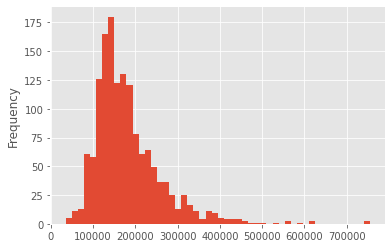

In [9]:
df_train['SalePrice'].plot(kind = 'hist', bins = 50)

In [10]:
#looking at correlation 
df.corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

<AxesSubplot:>

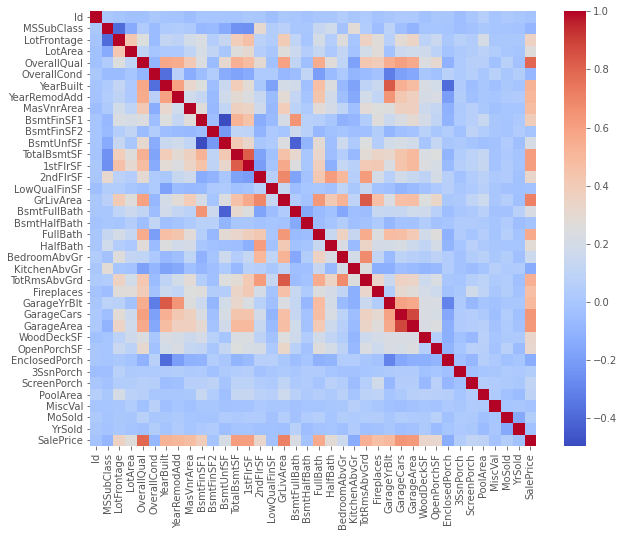

In [11]:
plt.figure(figsize= (10,8))
sns.heatmap(df_train.corr(), cmap= 'coolwarm')

# EDA & Imputing Null Values

In [12]:
# combining train and test values
data = pd.concat((df_train, df_test)).reset_index(drop=True)
x_saleprice = df_train["SalePrice"]
data.drop(["SalePrice"], axis = 1, inplace= True)
data.shape

(2919, 80)

<AxesSubplot:>

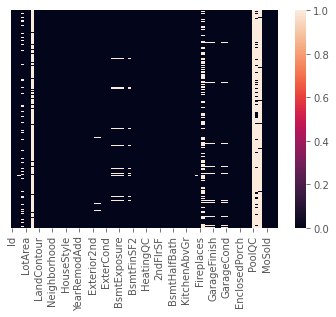

In [13]:
sns.heatmap(data.isna(), yticklabels= False)

In [15]:
#percent null values
((data.isnull().sum().sort_values(ascending = False) *100) / data.shape[0]).head(10)

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
dtype: float64

## Pool QC

In [16]:
data['PoolQC'].value_counts()

Gd    4
Ex    4
Fa    2
Name: PoolQC, dtype: int64

As observed, the absence of Pool QC implies there is no pool for the property and thus we will simply replace all null values to No as a category

In [17]:
data['PoolQC'].fillna("NA", inplace= True)

## Misc Feature

In [18]:
data['MiscFeature'].value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

As observed, the absence of value in Misc Feature implies there is no feature for the property and thus we will simply replace all null values to No as a category

In [19]:
data['MiscFeature'].fillna("NA", inplace= True)

## Alley

In [20]:
data['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

As observed, the absence of value in Alley implies there is no alley for the property and thus we will simply replace all null values to No as a category

In [21]:
data['Alley'].fillna("NA", inplace=True)

## Fence

In [22]:
data['Fence'].value_counts()

MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

As observed, the absence of value in Fence implies there is no fence for the property and thus we will simply replace all null values to No as a category

In [23]:
data['Fence'].fillna("NA", inplace= True)

## Fireplace QC

In [24]:
data['FireplaceQu'].value_counts()

Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64

As observed, the absence of value in Fireplace QC implies there is no fireplace for the property and thus we will simply replace all null values to No as a category

In [25]:
data['FireplaceQu'].fillna("NA", inplace= True)

## Lot Frontage

In [26]:
data.corr()['LotFrontage'].sort_values(ascending = False).nlargest(5)

LotFrontage    1.000000
LotArea        0.489896
1stFlrSF       0.458247
GrLivArea      0.382462
GarageArea     0.359786
Name: LotFrontage, dtype: float64

It appears that the frontage has high correaltion with Lot area. We will try to intrepret the missing values from this data

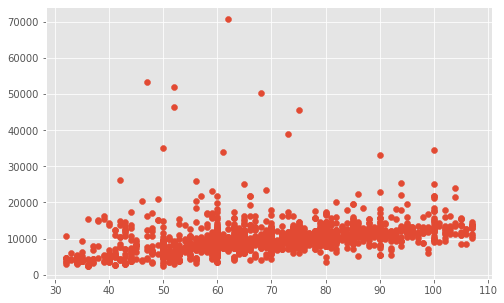

In [27]:
x = data['LotFrontage']
y = data['LotArea']
indices = x.between(x.quantile(.05), x.quantile(.95))
plt.figure(figsize=(8,5))
plt.scatter(x[indices],y[indices])

<AxesSubplot:xlabel='LotConfig', ylabel='LotFrontage'>

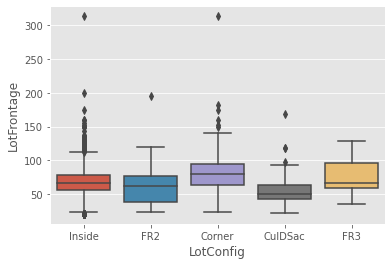

In [28]:
sns.boxplot(x = 'LotConfig', y = 'LotFrontage', data=data)

In [29]:
data[data['LotFrontage'].isna()].head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
7,8,60,RL,NaN,10382,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,Shed,350,11,2009,WD,Normal
12,13,20,RL,NaN,12968,Pave,NA,IR2,Lvl,AllPub,...,176,0,NA,NA,NA,0,9,2008,WD,Normal
14,15,20,RL,NaN,10920,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,GdWo,NA,0,5,2008,WD,Normal


<AxesSubplot:xlabel='MSZoning', ylabel='LotFrontage'>

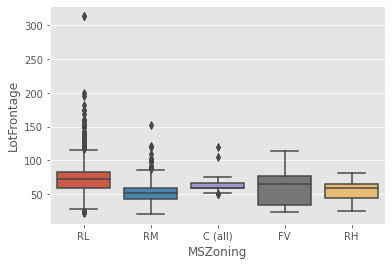

In [30]:
sns.boxplot(x = 'MSZoning', y = 'LotFrontage', data=data)

As we are not able to find any other parameter which might have high correlation, we will impute values to median value

In [31]:
median = data['LotFrontage'].median()
data['LotFrontage'].fillna(median, inplace=True)
print(median)

68.0


## Garage Features

GarageCond ; GarageYrBlt ;GarageFinish ;GarageQual ;GarageType

In [32]:
data[data['GarageType'].notna() & data['GarageCond'].isna()]['GarageType']

2126    Detchd
2576    Detchd
Name: GarageType, dtype: object

All the Garage related features exhibit similar characterstics i.e., haivng na value when there is no garage. We will impute the value No to all except Garaege Year Blt where we will make it zero as it highly punishes the variable for not having the garage

<AxesSubplot:ylabel='Frequency'>

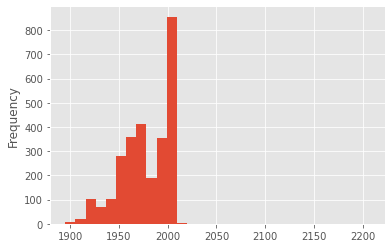

In [33]:
data['GarageYrBlt'].plot(kind = 'hist', bins = 30)

<AxesSubplot:ylabel='Frequency'>

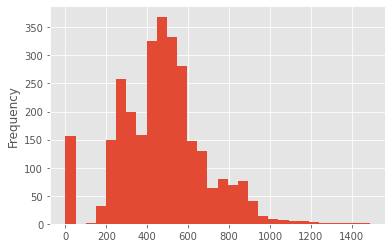

In [34]:
data['GarageArea'].plot(kind = 'hist', bins = 30)

This proves we have records with no garage

In [35]:
data['GarageCond'].fillna('NA', inplace= True)
data['GarageFinish'].fillna('NA', inplace= True)
data['GarageQual'].fillna('NA', inplace= True)
data['GarageType'].fillna('NA', inplace= True)
data['GarageYrBlt'].fillna(0, inplace= True)

## Basement

BsmtExposure    82
;BsmtCond        82
;BsmtQual        81
;BsmtFinType2    80
;BsmtFinType1

In [36]:
data['BsmtExposure'].fillna('NA', inplace= True)
data['BsmtCond'].fillna('NA', inplace= True)
data['BsmtQual'].fillna('NA', inplace= True)
data['BsmtFinType1'].fillna('NA', inplace= True)
data['BsmtFinType2'].fillna('NA', inplace= True)

## Masonary

MasVnrType      24
; MasVnrArea      23

In [37]:
data['MasVnrType'].value_counts()

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

<AxesSubplot:ylabel='Frequency'>

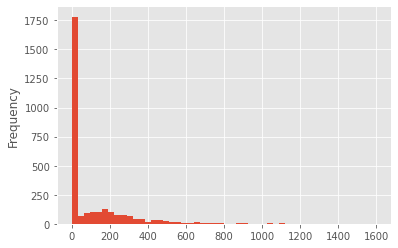

In [38]:
data['MasVnrArea'].plot(kind = 'hist', bins = 50)

In [39]:
data['MasVnrType'].fillna('None', inplace= True)
data['MasVnrArea'].fillna(0, inplace= True)

## Other

In [40]:
data['MSZoning'].fillna(data['MSZoning'].mode()[0], inplace= True)
data['Functional'].fillna(data['Functional'].mode()[0], inplace= True)
data['BsmtHalfBath'].fillna(data['BsmtHalfBath'].mode()[0], inplace= True)
data['BsmtFullBath'].fillna(data['BsmtFullBath'].mode()[0], inplace= True)

data['Utilities'].fillna(data['Utilities'].mode()[0], inplace= True)
data['Electrical'].fillna(data['Electrical'].mode()[0], inplace= True)
data['Exterior1st'].fillna(data['Exterior1st'].mode()[0], inplace= True)
data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0], inplace= True)

data['GarageCars'].fillna(data['GarageCars'].mode()[0], inplace= True)
data['GarageArea'].fillna(data['GarageArea'].mode()[0], inplace= True)
data['KitchenQual'].fillna(data['KitchenQual'].mode()[0], inplace= True)
data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].mode()[0], inplace= True)

data['SaleType'].fillna(data['SaleType'].mode()[0], inplace= True)
data['TotalBsmtSF'].fillna(data['TotalBsmtSF'].mode()[0], inplace= True)
data['BsmtUnfSF'].fillna(data['BsmtUnfSF'].mode()[0], inplace= True)
data['BsmtFinSF2'].fillna(data['BsmtFinSF2'].mode()[0], inplace= True)


## Using Label Encoder

In [41]:
categorical_columns = data.select_dtypes(include= ['object']).columns

In [42]:
from sklearn.preprocessing import LabelEncoder

In [43]:
encoder = LabelEncoder()

In [44]:
for col in categorical_columns :
    data[col] = encoder.fit_transform(data[col].astype(str))

In [45]:
data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,65.0,8450,1,1,3,3,0,...,0,0,3,4,1,0,2,2008,8,4
1,2,20,3,80.0,9600,1,1,3,3,0,...,0,0,3,4,1,0,5,2007,8,4
2,3,60,3,68.0,11250,1,1,0,3,0,...,0,0,3,4,1,0,9,2008,8,4


In [46]:
data.shape

(2919, 80)

# Creating Train & Test Datasets

In [52]:
train_df = data.iloc[:1460,:]  
train_df['SalePrice'] = x_saleprice
test_df = data.iloc[1460 :,:]  

In [53]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,1,3,3,0,...,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,1,3,3,0,...,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,1,0,3,0,...,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,1,0,3,0,...,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,1,0,3,0,...,0,3,4,1,0,12,2008,8,4,250000


In [54]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1460,1461,20,2,80.0,11622,1,1,3,3,0,...,120,0,3,2,1,0,6,2010,8,4
1461,1462,20,3,81.0,14267,1,1,0,3,0,...,0,0,3,4,0,12500,6,2010,8,4
1462,1463,60,3,74.0,13830,1,1,0,3,0,...,0,0,3,2,1,0,3,2010,8,4
1463,1464,60,3,78.0,9978,1,1,0,3,0,...,0,0,3,4,1,0,6,2010,8,4
1464,1465,120,3,43.0,5005,1,1,0,1,0,...,144,0,3,4,1,0,1,2010,8,4


In [55]:
X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df['SalePrice']
X_test = test_df

# Modeling 

In [56]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_log_error, r2_score

n_folds = 5

def evaluate_model(X_train,y_train, model) :
    cv = KFold(n_splits= 5, shuffle= True, random_state= 42).get_n_splits(X_train.values)
    msle = make_scorer(mean_squared_log_error)
    rmsle = np.sqrt(cross_val_score(model, X_train, y_train, cv = cv, scoring= msle))
    score_rmsle = [rmsle.mean()]
    return score_rmsle


## Linear Models

Creating baseline scores using linear models with regularizations

### Linear Regression

In [57]:
linear_regression = LinearRegression()
evaluate_model(X_train, y_train, linear_regression)

[0.17081948207488876]

### Lasso

In [67]:
error_list_1 = []

alpha= [0.01, 0.03, 0.1, 0.3, 1, 3,10,30,100, 300,1000,3000]

for num, a in enumerate(alpha) :
    lasso = Lasso(alpha=a, max_iter= 3000)
    error_1 = evaluate_model(X_train, y_train, lasso)
    error_list_1.append(error_1)

In [68]:
#alpha value for minimum error
alpha[error_list_1.index(min(error_list_1))]

1000

Lowest error value comes from alpha = 1000

In [69]:
lasso = Lasso(alpha= 1000, max_iter=10000)

In [71]:
evaluate_model(X_train, y_train, lasso)

[0.15997578369023785]

### Ridge

In [72]:
from sklearn.linear_model import Ridge

In [73]:
ridge = Ridge(alpha=500, copy_X=True, fit_intercept=True, max_iter=None, 
              normalize=False,  random_state=None, solver='auto', tol=0.001)

In [74]:
evaluate_model(X_train, y_train, ridge)

[0.16007628896081993]

## Support Vector 

In [75]:
from sklearn.svm import SVR

In [83]:
error_list = []
C = np.logspace(start=-5, stop=5, num=10, base= 10)

for c in C : 
    svr = SVR(C= c)
    error_list.append(evaluate_model(X_train, y_train, svr))

In [84]:
#value of C for minimum error
C[error_list.index(min(error_list))]

100000.0

In [85]:
min(error_list)

[0.21153142666536065]

## Decision Tree

In [86]:
from sklearn.tree import DecisionTreeRegressor

In [89]:
depths= [int(x) for x in np.linspace(5,100,10)]
error_list = []

for depth in depths :
    tree = DecisionTreeRegressor(max_depth= 5)
    error_list.append(evaluate_model(X_train, y_train, tree))

In [90]:
#value of C for minimum error
depths[error_list.index(min(error_list))]

36

In [91]:
min(error_list)

[0.20516033438122414]

## LightGBM

In [97]:
from sklearn.model_selection import train_test_split

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, random_state= 42, test_size= 0.3)

print(X_train2.shape)
print(X_val2.shape)

(1022, 80)
(438, 80)


In [103]:
import lightgbm as lgb
import optuna
from sklearn import metrics


def objective(trial):

    param = {
        'num_leaves' : trial.suggest_int('num_leaves', 20,500),\
        'n_estimators' : trial.suggest_int('n_estimators', 50,100),\
        'max_depth' : trial.suggest_int('max_depth', 5,80),\
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),\
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 500),\
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100.0),\
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100.0),\
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0)
    }

    lgb_model = lgb.LGBMRegressor(**param)
    lgb_model.fit(X_train2,y_train2, eval_set=[(X_val2,y_val2)],early_stopping_rounds=30,verbose=False)
    
    pred = lgb_model.predict(X_val2)
    error = -1 *(metrics.mean_squared_log_error(y_val2, pred))
    
    return error

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-07-24 22:40:50,561] A new study created in memory with name: no-name-c2aba565-d562-4cfb-ac96-26dcb01bee85
[I 2021-07-24 22:40:50,612] Trial 0 finished with value: -0.026083100966854338 and parameters: {'num_leaves': 266, 'n_estimators': 64, 'max_depth': 64, 'learning_rate': 0.10784139059091633, 'min_child_samples': 124, 'reg_alpha': 0.07937628444712726, 'reg_lambda': 0.0026195191648553185, 'colsample_bytree': 0.5744360808579311, 'subsample': 0.502476975991675}. Best is trial 0 with value: -0.026083100966854338.
[I 2021-07-24 22:40:50,650] Trial 1 finished with value: -0.04977754081089545 and parameters: {'num_leaves': 221, 'n_estimators': 70, 'max_depth': 27, 'learning_rate': 0.4615688981845972, 'min_child_samples': 482, 'reg_alpha': 0.23454335752652844, 'reg_lambda': 0.004846772543257154, 'colsample_bytree': 0.8635364331724156, 'subsample': 0.4875115397652148}. Best is trial 0 with value: -0.026083100966854338.
[I 2021-07-24 22:40:50,691] Trial 2 finished with value: -0.087116

[I 2021-07-24 22:40:52,225] Trial 20 finished with value: -0.018325961863758723 and parameters: {'num_leaves': 196, 'n_estimators': 57, 'max_depth': 36, 'learning_rate': 0.12326130896636424, 'min_child_samples': 41, 'reg_alpha': 4.16379795203976, 'reg_lambda': 7.154158717246126, 'colsample_bytree': 0.7541455972505506, 'subsample': 0.733714479355502}. Best is trial 13 with value: -0.018233178404315938.
[I 2021-07-24 22:40:52,378] Trial 21 finished with value: -0.01837815009539426 and parameters: {'num_leaves': 201, 'n_estimators': 57, 'max_depth': 36, 'learning_rate': 0.13107321866070296, 'min_child_samples': 10, 'reg_alpha': 4.519675405129034, 'reg_lambda': 5.97137139449817, 'colsample_bytree': 0.7664470807410455, 'subsample': 0.7383837061379979}. Best is trial 13 with value: -0.018233178404315938.
[I 2021-07-24 22:40:52,454] Trial 22 finished with value: -0.020389818332319395 and parameters: {'num_leaves': 120, 'n_estimators': 54, 'max_depth': 35, 'learning_rate': 0.1117767414158439, 

[I 2021-07-24 22:40:53,887] Trial 40 finished with value: -0.0834368323272129 and parameters: {'num_leaves': 235, 'n_estimators': 77, 'max_depth': 24, 'learning_rate': 0.013626584260154876, 'min_child_samples': 274, 'reg_alpha': 0.9867941125829441, 'reg_lambda': 0.5318697601179347, 'colsample_bytree': 0.9339933128549318, 'subsample': 0.44441191212515807}. Best is trial 13 with value: -0.018233178404315938.
[I 2021-07-24 22:40:54,038] Trial 41 finished with value: -0.018207660153335532 and parameters: {'num_leaves': 205, 'n_estimators': 57, 'max_depth': 33, 'learning_rate': 0.14811877142252222, 'min_child_samples': 14, 'reg_alpha': 4.838305695769587, 'reg_lambda': 6.590383096541103, 'colsample_bytree': 0.765923405403627, 'subsample': 0.7392978235944264}. Best is trial 41 with value: -0.018207660153335532.
[I 2021-07-24 22:40:54,141] Trial 42 finished with value: -0.01907505748376161 and parameters: {'num_leaves': 149, 'n_estimators': 56, 'max_depth': 33, 'learning_rate': 0.1853115572688

[I 2021-07-24 22:40:56,003] Trial 60 finished with value: -0.018443177876756527 and parameters: {'num_leaves': 95, 'n_estimators': 64, 'max_depth': 60, 'learning_rate': 0.17269666528002933, 'min_child_samples': 23, 'reg_alpha': 0.7482698637270473, 'reg_lambda': 2.4886462655856754, 'colsample_bytree': 0.7811220652095489, 'subsample': 0.6878733111779415}. Best is trial 49 with value: -0.01810933658641774.
[I 2021-07-24 22:40:56,093] Trial 61 finished with value: -0.018753271695041977 and parameters: {'num_leaves': 224, 'n_estimators': 57, 'max_depth': 49, 'learning_rate': 0.10609870123804192, 'min_child_samples': 43, 'reg_alpha': 3.8150042318797026, 'reg_lambda': 9.464164896144863, 'colsample_bytree': 0.8360650066246911, 'subsample': 0.7074905027181813}. Best is trial 49 with value: -0.01810933658641774.
[I 2021-07-24 22:40:56,251] Trial 62 finished with value: -0.01856850869785503 and parameters: {'num_leaves': 200, 'n_estimators': 57, 'max_depth': 45, 'learning_rate': 0.140651918237263

[I 2021-07-24 22:40:58,097] Trial 80 finished with value: -0.01907732731356683 and parameters: {'num_leaves': 381, 'n_estimators': 54, 'max_depth': 38, 'learning_rate': 0.3103598765685301, 'min_child_samples': 40, 'reg_alpha': 1.3090862033306623, 'reg_lambda': 23.923800579478247, 'colsample_bytree': 0.7689162203001019, 'subsample': 0.7182671680055249}. Best is trial 71 with value: -0.017805932354938308.
[I 2021-07-24 22:40:58,190] Trial 81 finished with value: -0.01932405732872978 and parameters: {'num_leaves': 227, 'n_estimators': 56, 'max_depth': 47, 'learning_rate': 0.10752767598970882, 'min_child_samples': 36, 'reg_alpha': 0.8510781372023021, 'reg_lambda': 14.76743179406599, 'colsample_bytree': 0.8068070192274196, 'subsample': 0.7318323611724318}. Best is trial 71 with value: -0.017805932354938308.
[I 2021-07-24 22:40:58,305] Trial 82 finished with value: -0.018526002102834293 and parameters: {'num_leaves': 165, 'n_estimators': 57, 'max_depth': 35, 'learning_rate': 0.12401454322946

In [112]:
lgbm_opt_params = study.best_trial.params
lgbm_opt_params

{'num_leaves': 210,
 'n_estimators': 56,
 'max_depth': 35,
 'learning_rate': 0.14651223030548316,
 'min_child_samples': 30,
 'reg_alpha': 4.775633315904766,
 'reg_lambda': 1.4028596243824722,
 'colsample_bytree': 0.7722908831538167,
 'subsample': 0.740848449330022}

# Submission 

Using LGBM Model & Lasso Model to create final submissions 

## Lasso Model 

In [105]:
lasso_model = Lasso(alpha= 1000, max_iter=10000)
lasso_model.fit(X_train, y_train)

Lasso(alpha=1000, max_iter=10000)

In [106]:
lasso_pred = lasso_model.predict(X_test)

In [109]:
lasso_submission = submission.copy()
lasso_submission['SalePrice'] = np.array(lasso_pred)

In [110]:
lasso_submission.head()

,Id,SalePrice
0,1461,120857.844402
1,1462,151704.314295
2,1463,171501.367030
3,1464,188697.171063
4,1465,199024.223865


In [111]:
lasso_submission.to_csv('lasso_submission.csv', index=False)

## LGBM Model

In [113]:
lgbm_model = lgb.LGBMRegressor(**lgbm_opt_params)
lgbm_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.7722908831538167,
              learning_rate=0.14651223030548316, max_depth=35,
              min_child_samples=30, n_estimators=56, num_leaves=210,
              reg_alpha=4.775633315904766, reg_lambda=1.4028596243824722,
              subsample=0.740848449330022)

In [114]:
lgbm_pred = lgbm_model.predict(X_test)

In [115]:
lgbm_submission = submission.copy()
lgbm_submission['SalePrice'] = np.array(lgbm_pred)

In [116]:
lgbm_submission.head()

,Id,SalePrice
0,1461,129154.547652
1,1462,154605.645834
2,1463,178899.967621
3,1464,187833.409289
4,1465,192201.662482


In [117]:
lgbm_submission.to_csv('lgbm_submission.csv',index=False)